In [29]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import sys
import os
script_dir = os.path.abspath("..")  # Go up one level from `train/`
sys.path.append(script_dir)
from model.model import *

## Load data for tensorflow

In [30]:
#train and test data directory
data_dir = "../dataset/dataset/train"
test_data_dir = "../dataset/dataset/test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((30,155)),transforms.ToTensor()
])) # transforms.Resize((32, 160))  # Keep aspect ratio close to original
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((30,155)),transforms.ToTensor()
]))
img, label = dataset[0]
print(img.shape,label)
print("Follwing classes are there : ",dataset.classes)

torch.Size([3, 30, 155]) 0
Follwing classes are there :  ['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


Label : 1


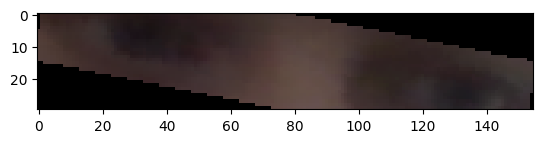

In [31]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [32]:
batch_size = 128
val_size = int(0.2*len(dataset))
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12802
Length of Validation Data : 3200


In [33]:
#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = os.cpu_count(), pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = os.cpu_count(), pin_memory = True)

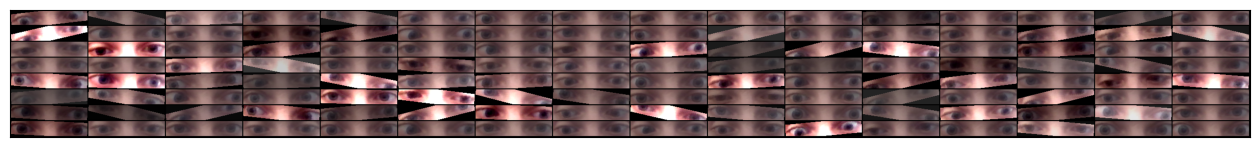

In [34]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

## Train

In [35]:
# Instantiate the model
model = ResNetModel(num_classes=100)
# Set up optimizer (you can experiment with learning rates)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Set the criterion (loss function)
criterion = nn.CrossEntropyLoss()
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
history = fit(15, 0.001, model, train_dl, val_dl, optim.Adam)

Epoch [0], train_loss: 2.1431, val_loss: 1.6677, val_acc: 0.4820
Epoch [1], train_loss: 0.7640, val_loss: 1.2879, val_acc: 0.6007
Epoch [2], train_loss: 0.5550, val_loss: 0.8406, val_acc: 0.7326
Epoch [3], train_loss: 0.5018, val_loss: 0.7789, val_acc: 0.7605
Epoch [4], train_loss: 0.4555, val_loss: 0.3917, val_acc: 0.8621
Epoch [5], train_loss: 0.3515, val_loss: 0.5020, val_acc: 0.8323
Epoch [6], train_loss: 0.2885, val_loss: 0.2915, val_acc: 0.8972
Epoch [7], train_loss: 0.2550, val_loss: 0.6484, val_acc: 0.7939
Epoch [8], train_loss: 0.2452, val_loss: 0.3030, val_acc: 0.9059
Epoch [9], train_loss: 0.2697, val_loss: 0.4405, val_acc: 0.8525
Epoch [10], train_loss: 0.4254, val_loss: 0.5748, val_acc: 0.8113
Epoch [11], train_loss: 0.2691, val_loss: 0.3324, val_acc: 0.8885
Epoch [12], train_loss: 0.2074, val_loss: 0.2541, val_acc: 0.9114
Epoch [13], train_loss: 0.2320, val_loss: 0.2809, val_acc: 0.9099
Epoch [14], train_loss: 0.2168, val_loss: 0.3365, val_acc: 0.8927


## Analyze Results 

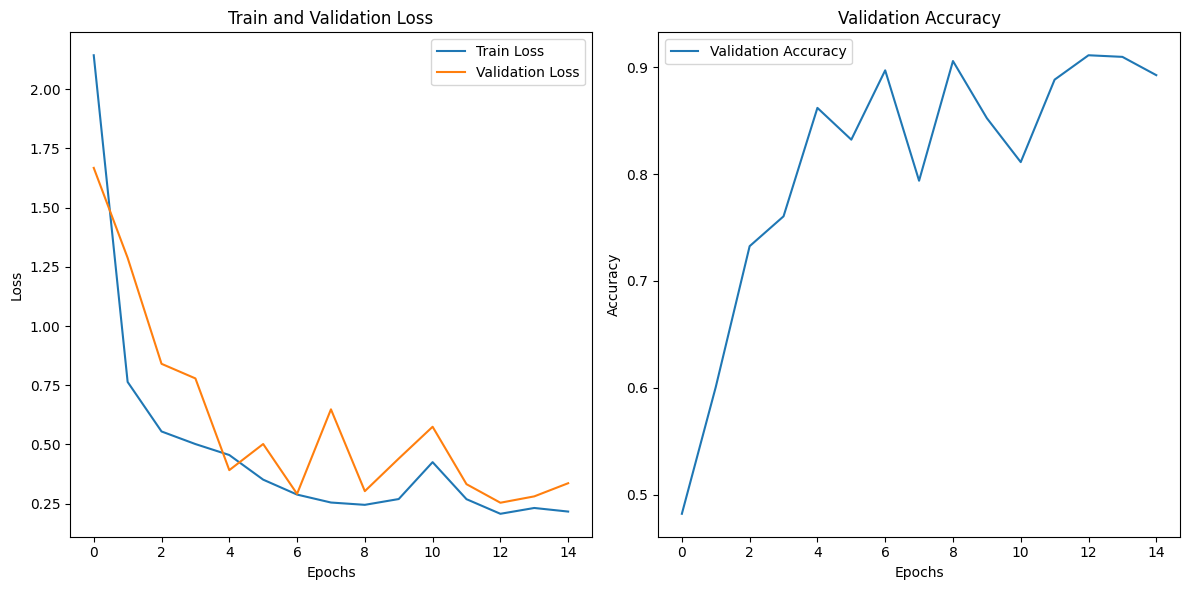

In [37]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values from history
train_losses = [x['train_loss'] for x in history]
val_losses = [x['val_loss'] for x in history]
val_accuracies = [x['val_acc'] for x in history]

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Test

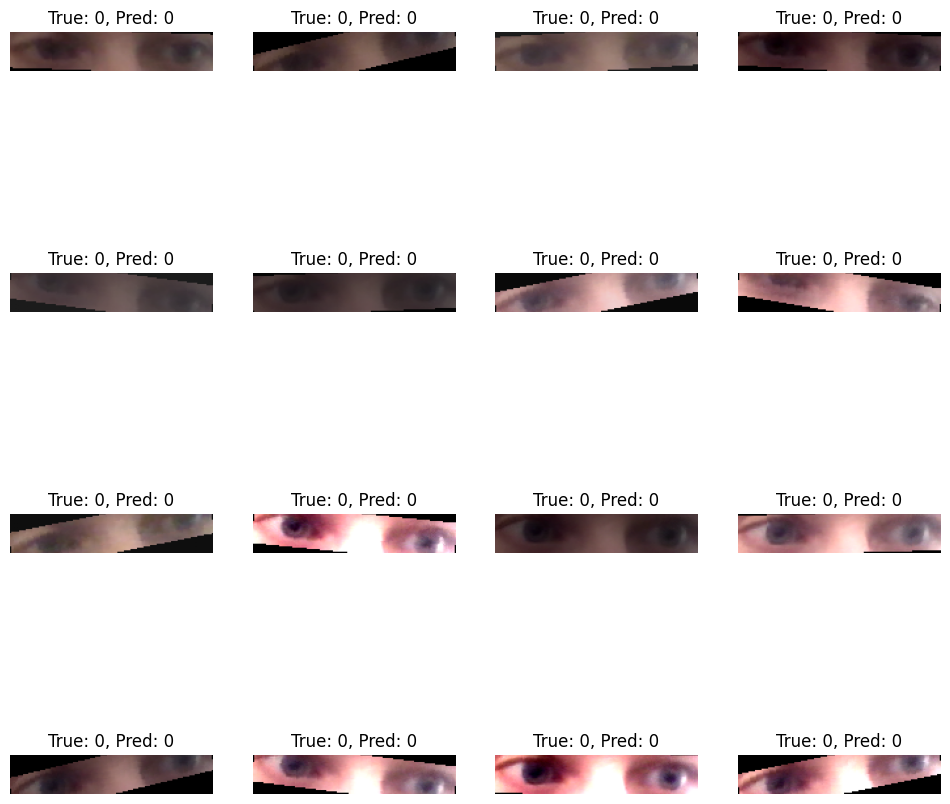

In [38]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Function to show images with labels and predictions
def show_predictions(model, loader):
    model.eval()
    images, labels = next(iter(loader))  # Get a batch of images and labels
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Plot images, true labels, and predicted labels
    plt.figure(figsize=(12, 12))
    for i in range(16):  # Show 16 images
        plt.subplot(4, 4, i+1)
        image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
        plt.imshow(image)
        true_label = labels[i].item()
        pred_label = preds[i].item()
        plt.title(f'True: {true_label}, Pred: {pred_label}')
        plt.axis('off')
    plt.show()

# Show predictions on a test batch
show_predictions(model, test_loader)

In [39]:
# Compute test accuracy
def test_accuracy(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

# Print the test accuracy
test_acc = test_accuracy(model, test_loader)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 90.15%


## Save Model

In [40]:
# Save the model's state_dict
torch.save(model.state_dict(), 'resnet_model.pth')
print("Model saved as 'resnet_model.pth'")

# To load the model later, you can use:
# model = ResNetModel(num_classes=100)
# model.load_state_dict(torch.load('resnet_model.pth'))
# model.eval()

Model saved as 'resnet_model.pth'


In [41]:
model = ResNetModel(num_classes=100)
model.load_state_dict(torch.load('resnet_model.pth'))
model.eval()

ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [42]:
from PIL import Image
# Function to predict the class of an folder of new images
folder_path = "../test/test_images" # inside we have n images named as <class_number>.jpg
def predict_folder(model, folder_path):
    img_files = os.listdir(folder_path)
    img_files = [f for f in img_files if f.endswith('.png')]
    img_files.sort()
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        print(img.size)
        #img = img.resize((30, 155))
        img = transforms.ToTensor()(img)
        img = img.unsqueeze(0)
        #img = img.to(device)
        model.eval()
        with torch.no_grad():
            out = model(img)
            _, pred = torch.max(out, 1)
            print(img_path, pred.item())

# Predict the classes of images in the folder
predict_folder(model, folder_path)

(155, 30)
../test/test_images\100.png 63
(155, 30)
../test/test_images\12.png 63
(155, 30)
../test/test_images\21.png 24
(155, 30)
../test/test_images\24.png 63
(155, 30)
../test/test_images\50.png 63
(155, 30)
../test/test_images\54.png 63
(155, 30)
../test/test_images\59.png 63
(155, 30)
../test/test_images\88.png 63
(155, 30)
../test/test_images\93.png 63


../test/test_images/100.png


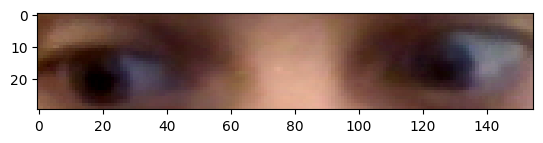

63


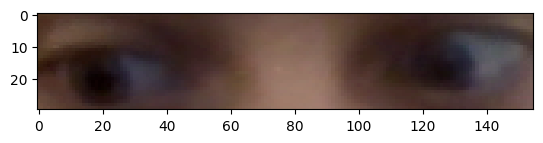

63


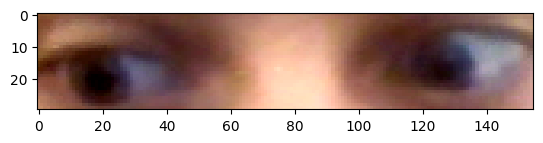

63


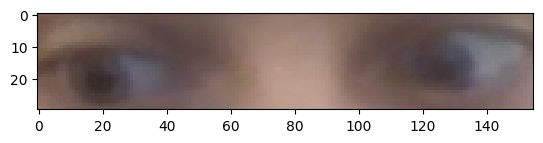

63


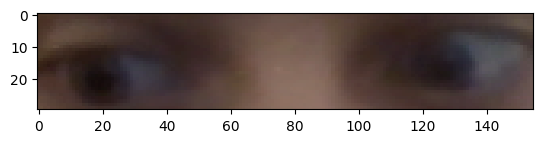

63


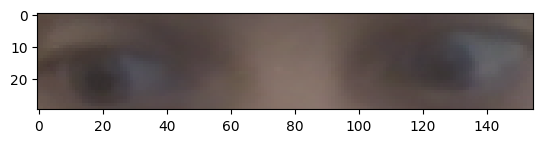

24


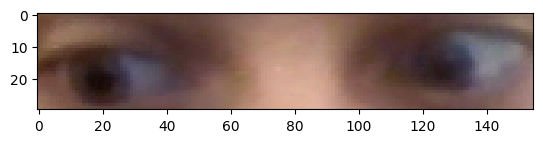

63


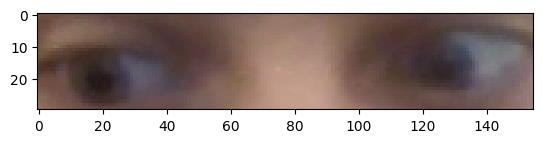

63


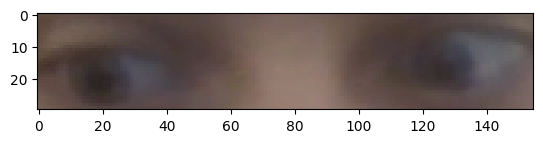

63


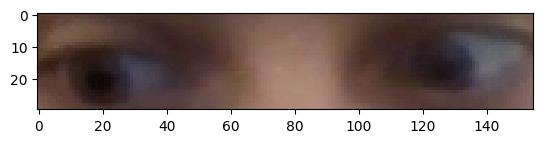

63


In [43]:
from PIL import ImageEnhance
import random

# predict 10 times the same image
image_path = "../test/test_images/100.png"
def predict_image(model, imge_path):
    print(imge_path)
    for i in range(10):
        img = Image.open(imge_path)
        # Random brightness & contrast adjustment
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.7, 1.3))
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.5, 2))
        # show image
        plt.imshow(img)
        plt.show()
        img = transforms.ToTensor()(img)
        img = img.unsqueeze(0)
        #img = img.to(device)
        model.eval()
        with torch.no_grad():
            out = model(img)
            _, pred = torch.max(out, 1)
            print(pred.item())

# Predict the classes of images in the folder
predict_image(model, image_path)